In [130]:
import pandas as pd
import numpy as np
import patsy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import metrics
from sklearn.grid_search import GridSearchCV

In [2]:
# import dataset
jobs = pd.read_csv('/Users/teresaborcuch/jobs_df.csv')

In [3]:
del jobs['Unnamed: 0']

In [4]:
jobs.head()

,id,Python,over_90k,has_phd,years,has_startup,title,company,scientist_title,analyst_title
0,jl_f43cd8061406b3d7,1.0,1.0,0.0,NaN,0.0,Director of Data Science and Analysis,Fidelity Investments,0,0
1,jl_90603c7f1f0af480,1.0,1.0,0.0,0.0,0.0,Analytics Engineer (Boston),QuantumBlack,0,0
2,jl_50022587c7a4a8d9,1.0,1.0,0.0,0.0,0.0,Data Scientist Intern: Pricing & Profitability...,Wayfair,1,0
3,jl_44da2bd2b0b7e145,1.0,1.0,1.0,0.0,0.0,Machine Learning Scientist,Amazon Corporate LLC,1,0
4,jl_f5945f64ec7013e3,1.0,1.0,0.0,0.0,0.0,Data Scientist,MIT,1,0


In [5]:
jobs.dropna(subset = ['over_90k'], inplace = True)
jobs['years'].fillna(0, inplace = True)
jobs['years'] = jobs['years'].astype('int')
jobs['Python'] = jobs['Python'].astype('category')
jobs['has_phd'] = jobs['has_phd'].astype('category')
jobs['has_startup'] = jobs['has_startup'].astype('category')
jobs['scientist_title'] = jobs['scientist_title'].astype('category')
jobs['analyst_title'] = jobs['analyst_title'].astype('category')
jobs['over_90k'] = jobs['over_90k'].astype('category')

In [6]:
len(jobs['id'].unique())

627

In [7]:
# Now we have 627 jobs ready to go 
jobs.shape

(627, 10)

In [8]:
jobs.dtypes

id                   object
Python             category
over_90k           category
has_phd            category
years                 int64
has_startup        category
title                object
company              object
scientist_title    category
analyst_title      category
dtype: object

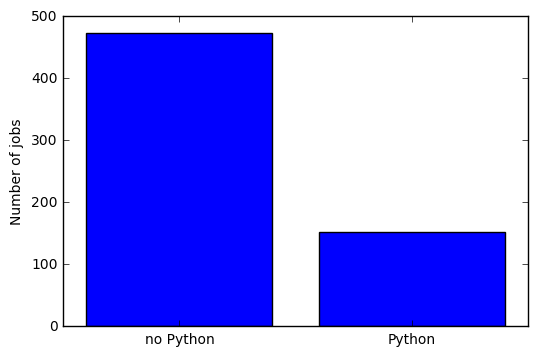

In [237]:
plt.bar([1,2],jobs['Python'].value_counts(), align = 'center')
plt.xticks([1,2], ['no Python','Python'])
plt.ylabel('Number of jobs')
plt.show()

In [175]:
jobs.to_csv('/Users/teresaborcuch/Desktop/jobs.csv')

I'll build a logistic regression model that considers particular terms in a job's title and description and uses these to predict whether the job pays over 90k or not. This analysis will identify which factors are the best predictors of high salary, construct and optimize a model using cross-validation, and evaluate its performance on a novel test subset of data.

In [137]:
# Create matrices of predictors and targets
X = jobs[['Python','has_phd','years','has_startup','scientist_title','analyst_title']]
y = jobs.over_90k

In [138]:
# make dummies for year
cat_X = patsy.dmatrix('~C(years) + C(Python) + C(has_phd) + C(has_startup) + C(scientist_title) + C(analyst_title)', jobs)

In [139]:
X.shape

(627, 6)

In [140]:
# use gridsearch to find best value of C and regularization type to optimize model
logreg = linear_model.LogisticRegression()
C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty':penalties, 'C':C_vals}, verbose = True, cv = 5, scoring = 'f1_macro')
gs.fit(cat_X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_macro',
       verbose=True)

In [141]:
gs.best_params_

{'C': 2.5, 'penalty': 'l2'}

The best model has C = 100.0 and uses L1 regularization penalty.

In [144]:
# Fit a model with these hyperparameters
gs_logreg = linear_model.LogisticRegression(C = 2.5, penalty = 'l2', solver = 'liblinear')
gs_logreg.fit(cat_X,y)

LogisticRegression(C=2.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [145]:
predictions = gs_logreg.predict(cat_X)

In [146]:
# Make confusion matrix
conmat= metrics.confusion_matrix(y, predictions, labels=gs_logreg.classes_)
conmat= pd.DataFrame(conmat, columns=gs_logreg.classes_, index=gs_logreg.classes_)
print conmat

     0.0  1.0
0.0  219   92
1.0  106  210


In [147]:
# Evaluate model
print metrics.classification_report(y, predictions)

             precision    recall  f1-score   support

        0.0       0.67      0.70      0.69       311
        1.0       0.70      0.66      0.68       316

avg / total       0.68      0.68      0.68       627



In [156]:
gs_logreg.coef_[0]

array([-0.24498281, -0.71210111,  0.00377296,  0.46087413,  0.95138665,
        1.32299233,  0.77710802,  1.37981723, -0.17454109, -0.79785135])

In [157]:
cat_X

DesignMatrix with shape (627, 10)
  Columns:
    ['Intercept',
     'C(years)[T.1]',
     'C(years)[T.2]',
     'C(years)[T.3]',
     'C(years)[T.4]',
     'C(Python)[T.1.0]',
     'C(has_phd)[T.1.0]',
     'C(has_startup)[T.1.0]',
     'C(scientist_title)[T.1]',
     'C(analyst_title)[T.1]']
  Terms:
    'Intercept' (column 0)
    'C(years)' (columns 1:5)
    'C(Python)' (column 5)
    'C(has_phd)' (column 6)
    'C(has_startup)' (column 7)
    'C(scientist_title)' (column 8)
    'C(analyst_title)' (column 9)
  (to view full data, use np.asarray(this_obj))

In [159]:
# Get coefficients
var = ['Intercept',
     'C(years)[T.1]',
     'C(years)[T.2]',
     'C(years)[T.3]',
     'C(years)[T.4]',
     'C(Python)[T.1.0]',
     'C(has_phd)[T.1.0]',
     'C(has_startup)[T.1.0]',
     'C(scientist_title)[T.1]',
     'C(analyst_title)[T.1]']
coef = gs_logreg.coef_[0]
coefs = []
for i in range(0,10):
    coefs.append(coef[i])
model_summary = pd.DataFrame(columns = ['variable','coefficient'])
model_summary['variable'] = var
model_summary['coefficient'] = coefs
model_summary = model_summary.sort_values('coefficient', ascending = False)
model_summary

,variable,coefficient
7,C(has_startup)[T.1.0],1.379817
5,C(Python)[T.1.0],1.322992
4,C(years)[T.4],0.951387
6,C(has_phd)[T.1.0],0.777108
3,C(years)[T.3],0.460874
2,C(years)[T.2],0.003773
8,C(scientist_title)[T.1],-0.174541
0,Intercept,-0.244983
1,C(years)[T.1],-0.712101
9,C(analyst_title)[T.1],-0.797851


In [81]:
# get the testjobs for testing data
# these are all new jobs collected between 12/21 and 12/28 using same methodology
testjobs = pd.read_csv('/Users/teresaborcuch/Desktop/testjobs.csv')

In [82]:
testjobs.head()

,Unnamed: 0,job_id,title,company,has_phd,has_python,over_90k,has_startup,years,scientist_title,analyst_title
0,0,jl_ce0b88780585db5e,Quantitative Data Analyst Intern,NaN,0.0,1.0,0.0,1.0,0.0,0,1
1,1,jl_166b32fc833354f5,Research Coordinator - Friedman School of Nutr...,NaN,0.0,0.0,0.0,0.0,0.0,0,0
2,2,jl_df3319bfb55ad3cf,Principal Data Scientist (Boston),NaN,1.0,1.0,1.0,0.0,0.0,1,0
3,3,jl_9a7d42c7e9942208,Data Scientist,NaN,0.0,1.0,1.0,1.0,0.0,1,0
4,4,jl_ee7e2f3d59a27997,Data Scientist II,NaN,0.0,0.0,0.0,0.0,0.0,1,0


In [83]:
del testjobs['Unnamed: 0']

In [84]:
del testjobs['company']

In [85]:
testjobs.dtypes

job_id              object
title               object
has_phd            float64
has_python         float64
over_90k           float64
has_startup        float64
years              float64
scientist_title      int64
analyst_title        int64
dtype: object

In [86]:
testjobs.dropna(subset = ['over_90k'], inplace = True)
testjobs['years'] = jobs['years'].astype('int')
testjobs['Python'] = jobs['Python'].astype('category')
testjobs['has_phd'] = jobs['has_phd'].astype('category')
testjobs['has_startup'] = jobs['has_startup'].astype('category')
testjobs['scientist_title'] = jobs['scientist_title'].astype('category')
testjobs['analyst_title'] = jobs['analyst_title'].astype('category')
testjobs['over_90k'] = jobs['over_90k'].astype('category')

In [87]:
testjobs = testjobs.drop_duplicates(subset = 'job_id')

In [88]:
testjobs = testjobs.dropna()

In [89]:
testjobs.shape

(350, 10)

In [106]:
# how many of these jobs are actually new?
count = 0
for i, row in testjobs.iterrows():
    if row.iloc[0] in jobs['id'].values:
        print row
        print i

job_id             jl_a3ee1268e985e69b
title              Research Analyst II
has_phd                              0
has_python                           0
over_90k                             1
has_startup                          0
years                                0
scientist_title                      0
analyst_title                        0
Python                               1
Name: 42, dtype: object
42


In [113]:
testjobs.loc[42]

job_id             jl_a3ee1268e985e69b
title              Research Analyst II
has_phd                              0
has_python                           0
over_90k                             1
has_startup                          0
years                                0
scientist_title                      0
analyst_title                        0
Python                               1
Name: 42, dtype: object

In [114]:
testjobs.drop(42, axis = 0)

,job_id,title,has_phd,has_python,over_90k,has_startup,years,scientist_title,analyst_title,Python
0,jl_ce0b88780585db5e,Quantitative Data Analyst Intern,0.0,1.0,1.0,0.0,0.0,0,0,1.0
1,jl_166b32fc833354f5,Research Coordinator - Friedman School of Nutr...,0.0,0.0,1.0,0.0,0.0,0,0,1.0
2,jl_df3319bfb55ad3cf,Principal Data Scientist (Boston),0.0,1.0,1.0,0.0,0.0,1,0,1.0
3,jl_9a7d42c7e9942208,Data Scientist,1.0,1.0,1.0,0.0,0.0,1,0,1.0
4,jl_ee7e2f3d59a27997,Data Scientist II,0.0,0.0,1.0,0.0,0.0,1,0,1.0
5,jl_1f1198f76898781f,Data Scientist,1.0,1.0,1.0,0.0,3.0,0,1,1.0
6,jl_04bc09cfa0aed47c,Quantitative Data Analyst,1.0,1.0,1.0,0.0,4.0,1,0,1.0
7,jl_91c7efe451686ad0,Research Data Assistant-institutional Effectiv...,0.0,0.0,0.0,0.0,0.0,1,0,1.0
8,jl_3692ec266c2e0789,Analytics & Reporting Specialist,0.0,0.0,1.0,0.0,2.0,1,0,1.0
9,jl_dd84d4b5e0fc275c,Mid - Senior Data Engineer (Java),0.0,0.0,1.0,0.0,3.0,1,0,1.0


In [176]:
testjobs.to_csv('/Users/teresaborcuch/Desktop/test_jobs_clean.csv')

In [168]:
# make test jobs matrix
test_X = patsy.dmatrix('~C(years) + C(Python) + C(has_phd) + C(has_startup) + C(scientist_title) + C(analyst_title)', testjobs)

In [169]:
# test the model on the testjobs
pred_testjobs = gs_logreg.predict(test_X)

In [170]:
pred_testjobs.shape

(350,)

In [181]:
y_test = testjobs.over_90k

In [172]:
y.shape

(350,)

In [173]:
# Make confusion matrix
conmat1= metrics.confusion_matrix(y, pred_testjobs, labels=gs_logreg.classes_)
conmat1= pd.DataFrame(conmat1, columns=gs_logreg.classes_, index=gs_logreg.classes_)
print conmat1

     0.0  1.0
0.0  157   78
1.0    2  113


In [174]:
# evaluate performance on test set
print metrics.classification_report(y, pred_testjobs)

             precision    recall  f1-score   support

        0.0       0.99      0.67      0.80       235
        1.0       0.59      0.98      0.74       115

avg / total       0.86      0.77      0.78       350



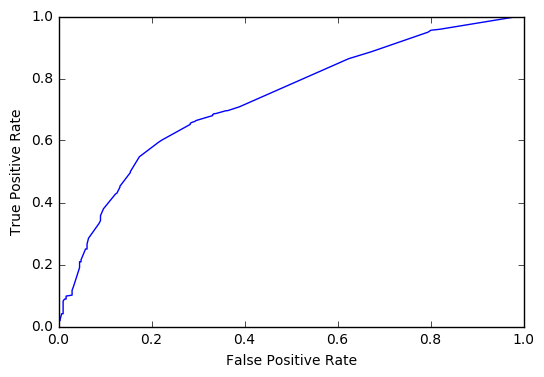

Area under the curve:  0.733668443974


In [195]:
# Plot ROC curve for train data
from sklearn.metrics import roc_curve, auc
y_score = gs_logreg.decision_function(cat_X)
y = jobs.over_90k

FPR = dict()
TPR = dict()
ROC_AUC = dict()

FPR[1], TPR[1], _ = roc_curve(y, y_score, pos_label = 1)

ROC_AUC[1] = auc(FPR[1], TPR[1])

plt.plot(FPR[1], TPR[1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

print "Area under the curve: ", ROC_AUC[1]

In [190]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y, y_score)

0.73366844397411368

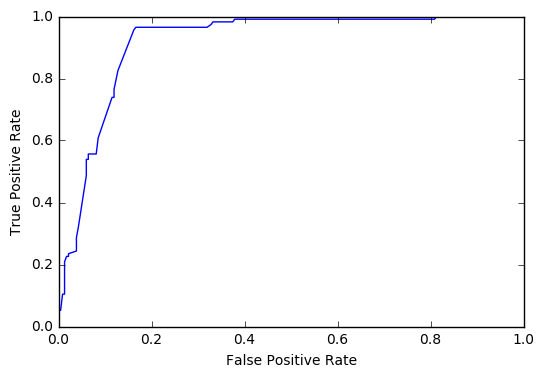

In [182]:
# Plot ROC curve for test data
from sklearn.metrics import roc_curve, auc
y_score = gs_logreg.decision_function(test_X)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

FPR[1], TPR[1], _ = roc_curve(y_test, y_score)

ROC_AUC[1] = auc(FPR[1], TPR[1])

plt.plot(FPR[1], TPR[1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()